# Introduction

The notebook is intended to analyse the weather outside conditions to find correlations with the inside air pollutions.

[Data](https://opendata.swiss/en/dataset/stundlich-aktualisierte-meteodaten-seit-1992)

In [1]:
# Import Standard Libraries
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

import seaborn as sns

from functools import reduce

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Notebook's variables
weather_2022_data_file = './../data/ugz_ogd_meteo_h1_2022.csv'
sensirion_data_file = './../data/20220915_HackZurich_Sensirion_v1.csv'

# Read Data

In [4]:
# Read precipitation data
weather_2022_data = pd.read_csv(weather_2022_data_file,
                                parse_dates=['Datum'])

sensirion_data = pd.read_csv(sensirion_data_file, 
                             parse_dates=['Unnamed: 0'])

# Fix Datetime
weather_2022_data['Datum'] = weather_2022_data['Datum'].apply(lambda row: row.replace(tzinfo=None))

# Rename columns
sensirion_data['Datum'] = sensirion_data['Unnamed: 0']
sensirion_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
weather_2022_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datum      136950 non-null  datetime64[ns]
 1   Standort   136950 non-null  object        
 2   Parameter  136950 non-null  object        
 3   Intervall  136950 non-null  object        
 4   Einheit    136950 non-null  object        
 5   Wert       136476 non-null  float64       
 6   Status     136950 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 7.3+ MB


In [6]:
sensirion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69985 entries, 0 to 69984
Data columns (total 31 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   temperature_ventilation_system_fresh_air_in            50974 non-null  float64       
 1   temperature_ventilation_system_fresh_air_intermediate  50974 non-null  float64       
 2   temperature_ventilation_system_fresh_air_out           50974 non-null  float64       
 3   temperature_ventilation_system_used_air_in             50974 non-null  float64       
 4   temperature_ventilation_system_used_air_out            50974 non-null  float64       
 5   volumne_flow_ventitaltion_system_in                    50974 non-null  float64       
 6   particulate_matter_outdoor_measured                    69780 non-null  float64       
 7   temperature_outdoor                                    69780 non-nu

In [7]:
weather_2022_data.head()

,Datum,Standort,Parameter,Intervall,Einheit,Wert,Status
0,2022-01-01,Zch_Stampfenbachstrasse,T,h1,°C,7.22,provisorisch
1,2022-01-01,Zch_Stampfenbachstrasse,Hr,h1,%Hr,82.93,provisorisch
2,2022-01-01,Zch_Stampfenbachstrasse,p,h1,hPa,977.20,provisorisch
3,2022-01-01,Zch_Stampfenbachstrasse,RainDur,h1,min,0.00,provisorisch
4,2022-01-01,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,provisorisch


In [8]:
sensirion_data.head()

,temperature_ventilation_system_fresh_air_in,temperature_ventilation_system_fresh_air_intermediate,temperature_ventilation_system_fresh_air_out,temperature_ventilation_system_used_air_in,temperature_ventilation_system_used_air_out,volumne_flow_ventitaltion_system_in,particulate_matter_outdoor_measured,temperature_outdoor,humidity_outdoor_measured,temperature_outdoor_estimated,...,co2_room_B,particulate_matter_room_A,tvoc_room_A,temperature_room_B,humidity_room_B,particulate_matter_room_B,no2_room_B,tvoc_room_B,consumed_meals,Datum
0,NaN,NaN,NaN,NaN,NaN,NaN,0.382250,6.8924,42.4059,7.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-05-02 00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,0.379375,6.9073,42.3694,6.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-05-02 00:10:00
2,NaN,NaN,NaN,NaN,NaN,NaN,0.474375,6.8834,42.3726,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-05-02 00:20:00
3,NaN,NaN,NaN,NaN,NaN,NaN,0.402085,6.8325,42.4241,6.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-05-02 00:30:00
4,NaN,NaN,NaN,NaN,NaN,NaN,0.346685,6.8003,42.4528,6.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-05-02 00:40:00


# Exploratory Data Analysis

## NaN Values

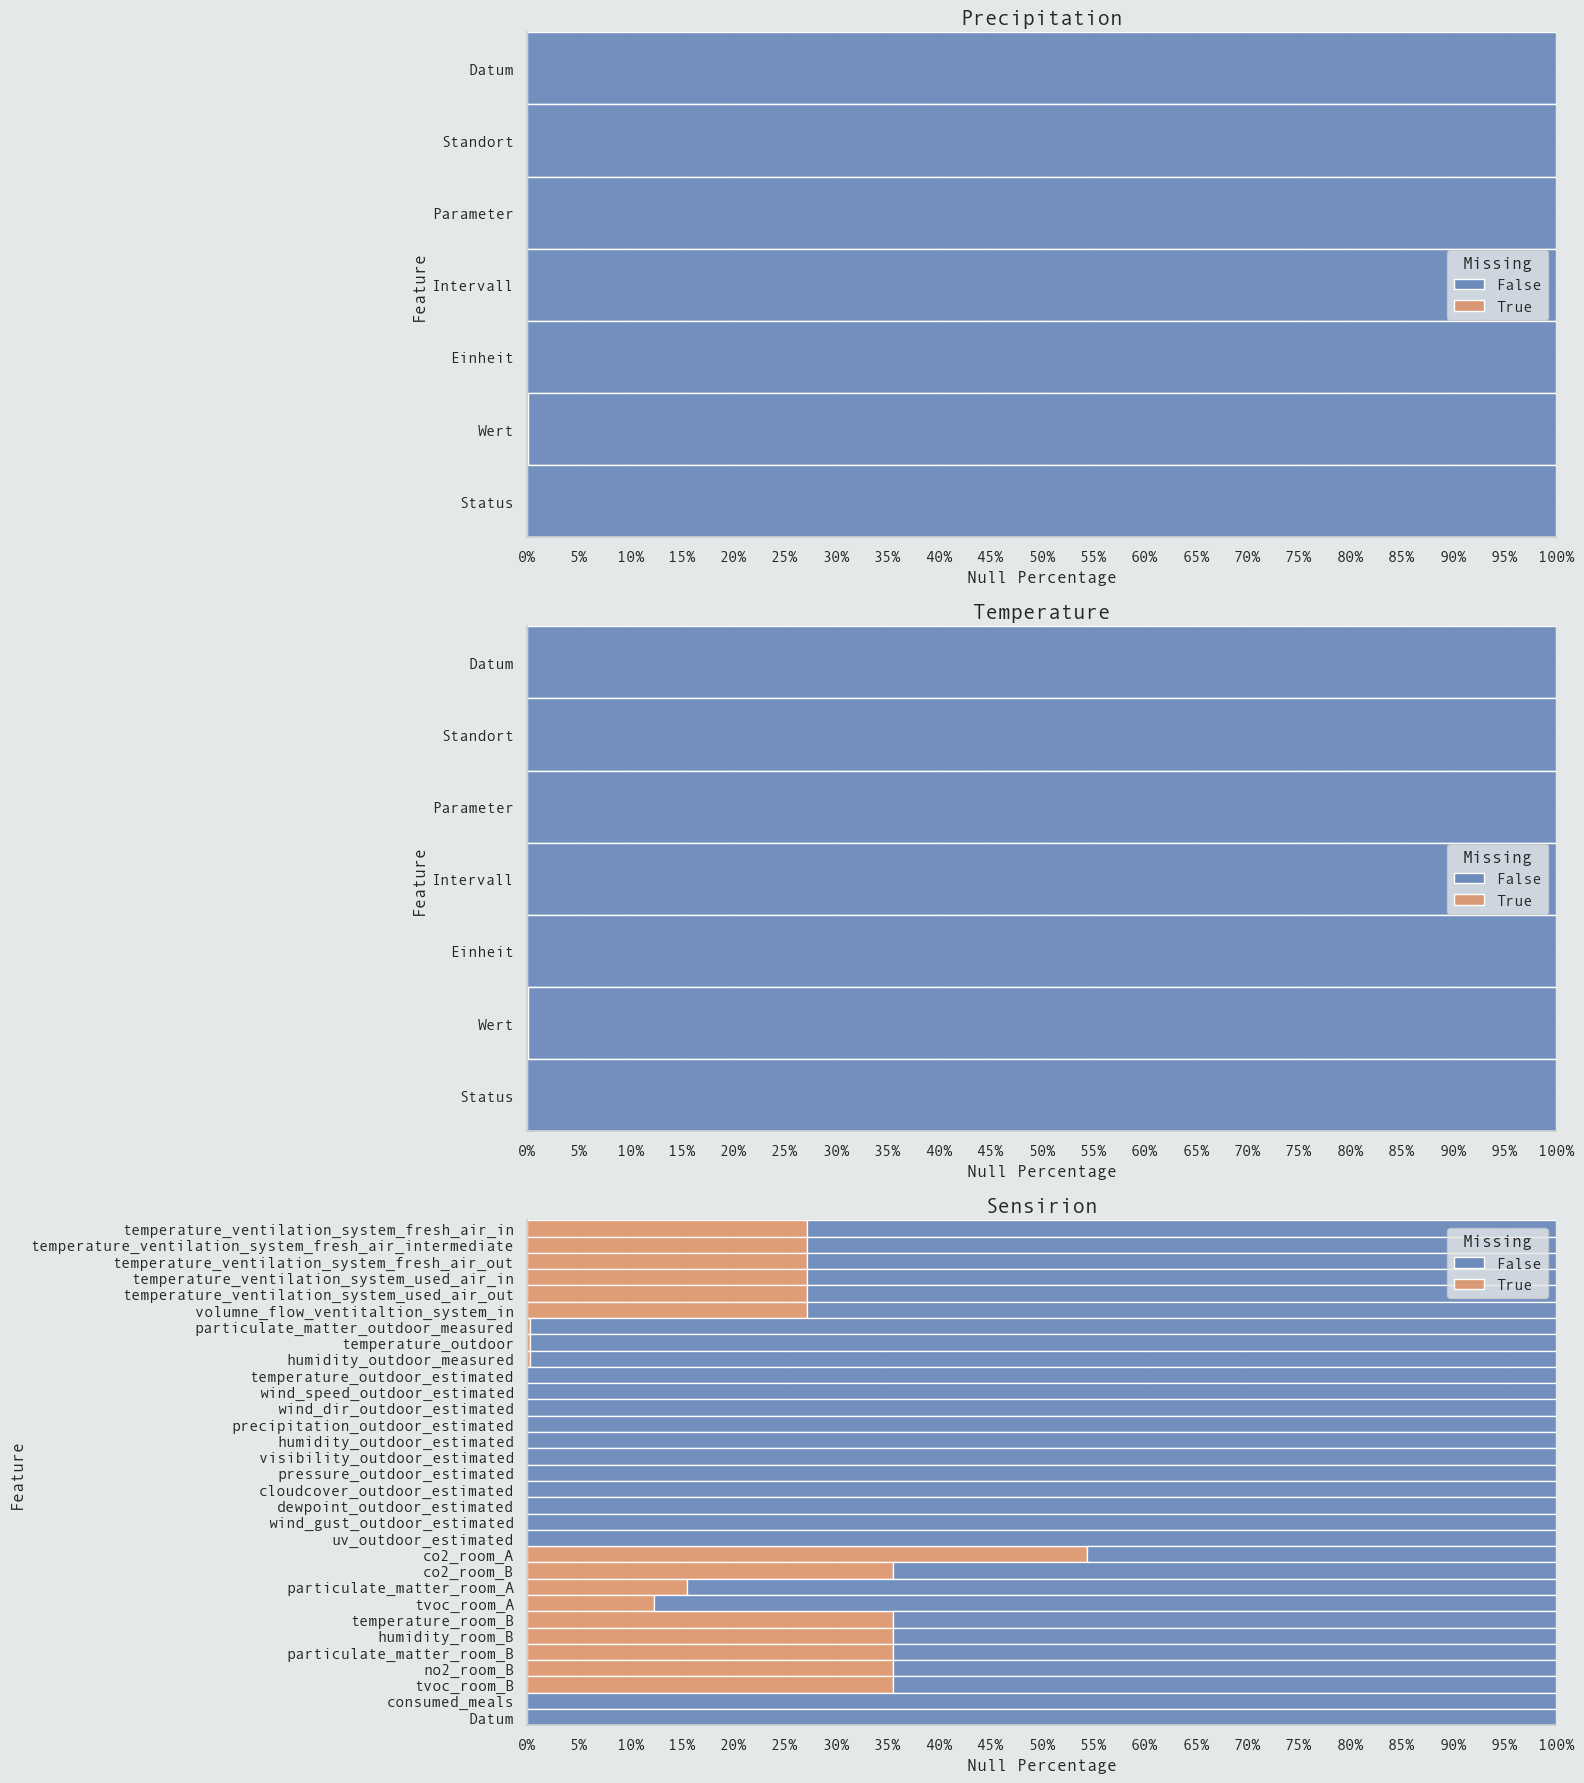

In [9]:
# Define data to display
data_to_display = {
    'Precipitation': weather_2022_data[weather_2022_data['Parameter'] == 'RainDur'],
    'Temperature': weather_2022_data[weather_2022_data['Parameter'] == 'T'],
    'Sensirion': sensirion_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(16, 18))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

## Precipitations over Time

In [10]:
# Retrieve only precipitations
precipitations_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'RainDur']

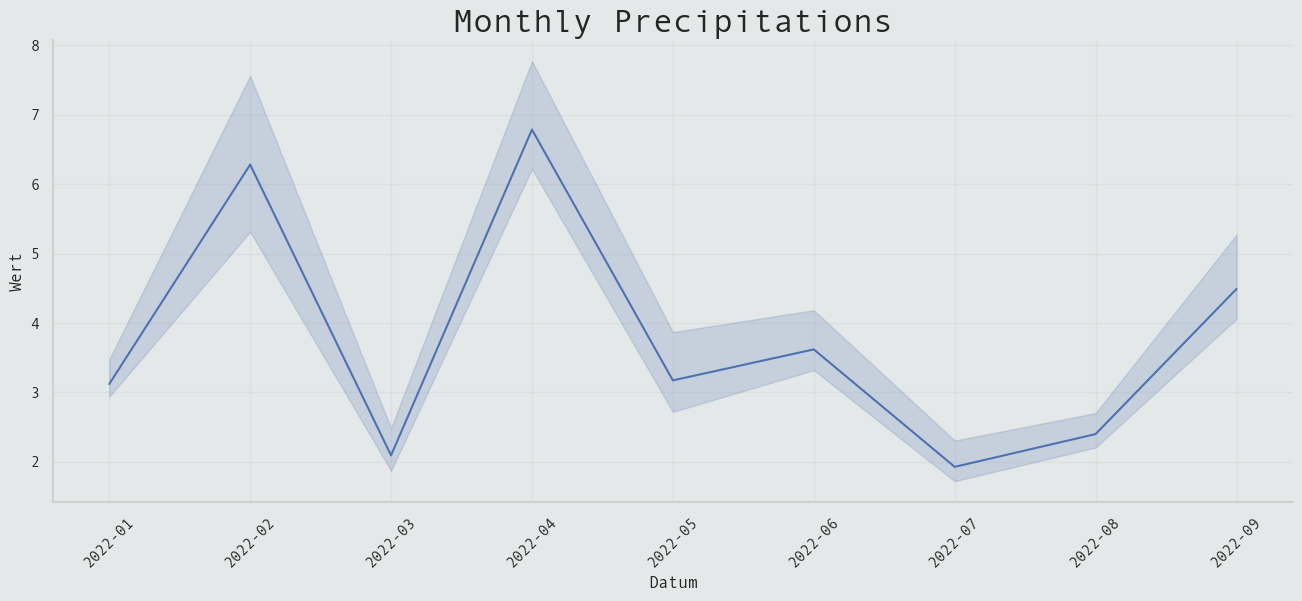

In [11]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Monthly Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

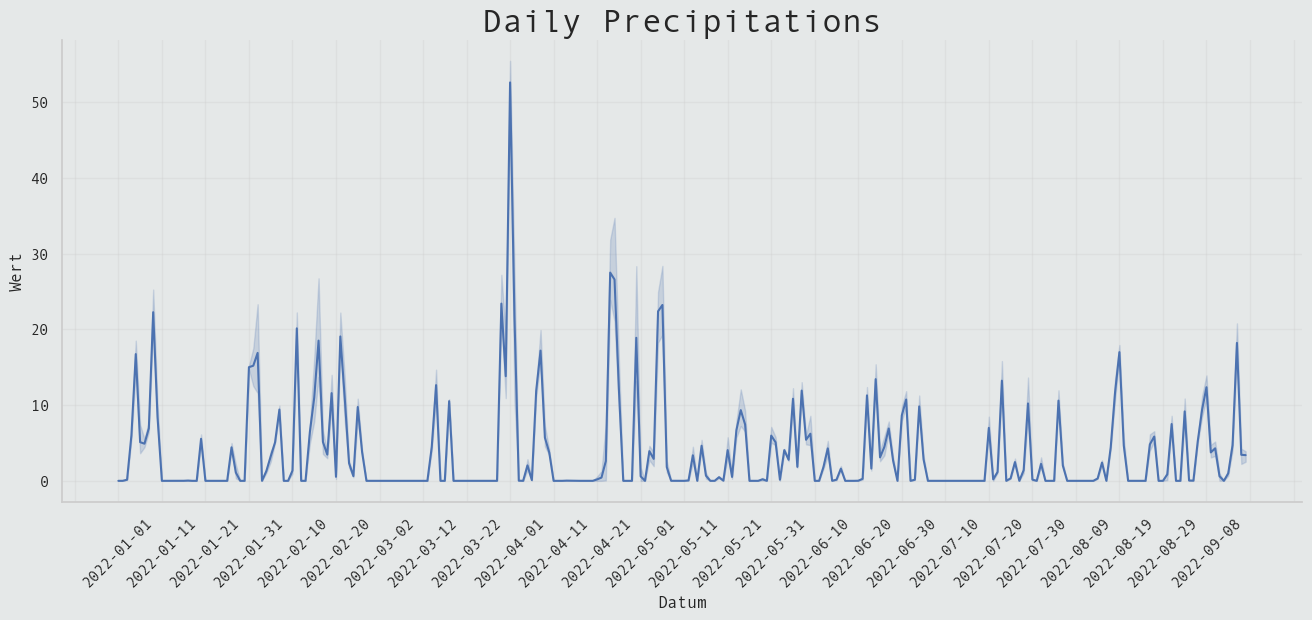

In [12]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m-%d'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Temperature over Time

In [13]:
# Retrieve only temperatures
temperatures_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'T']

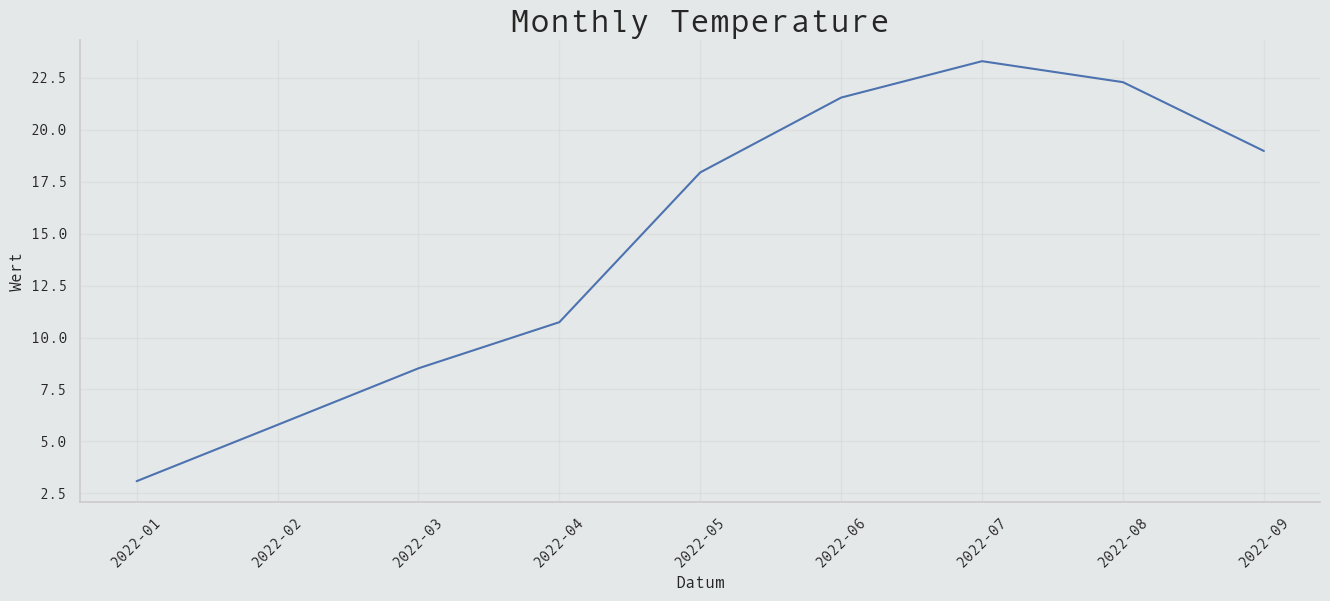

In [14]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m')
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert', 
)

ax.set_title('Monthly Temperature')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

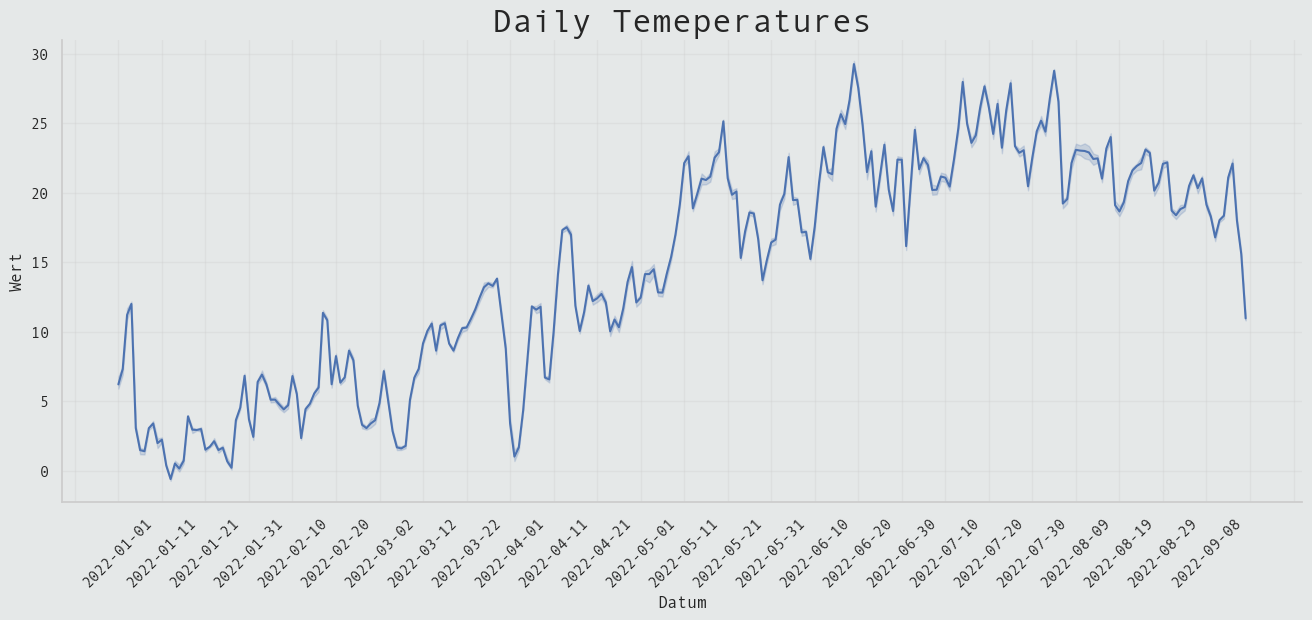

In [15]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m-%d'),
        temperatures_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Temeperatures')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Daily Precipitations & Temepratures

In [16]:
# Retrieve only precipitations & temperatures
precipitations_temperatures_2022 = weather_2022_data[(weather_2022_data['Parameter'] == 'RainDur') | (weather_2022_data['Parameter'] == 'T')]

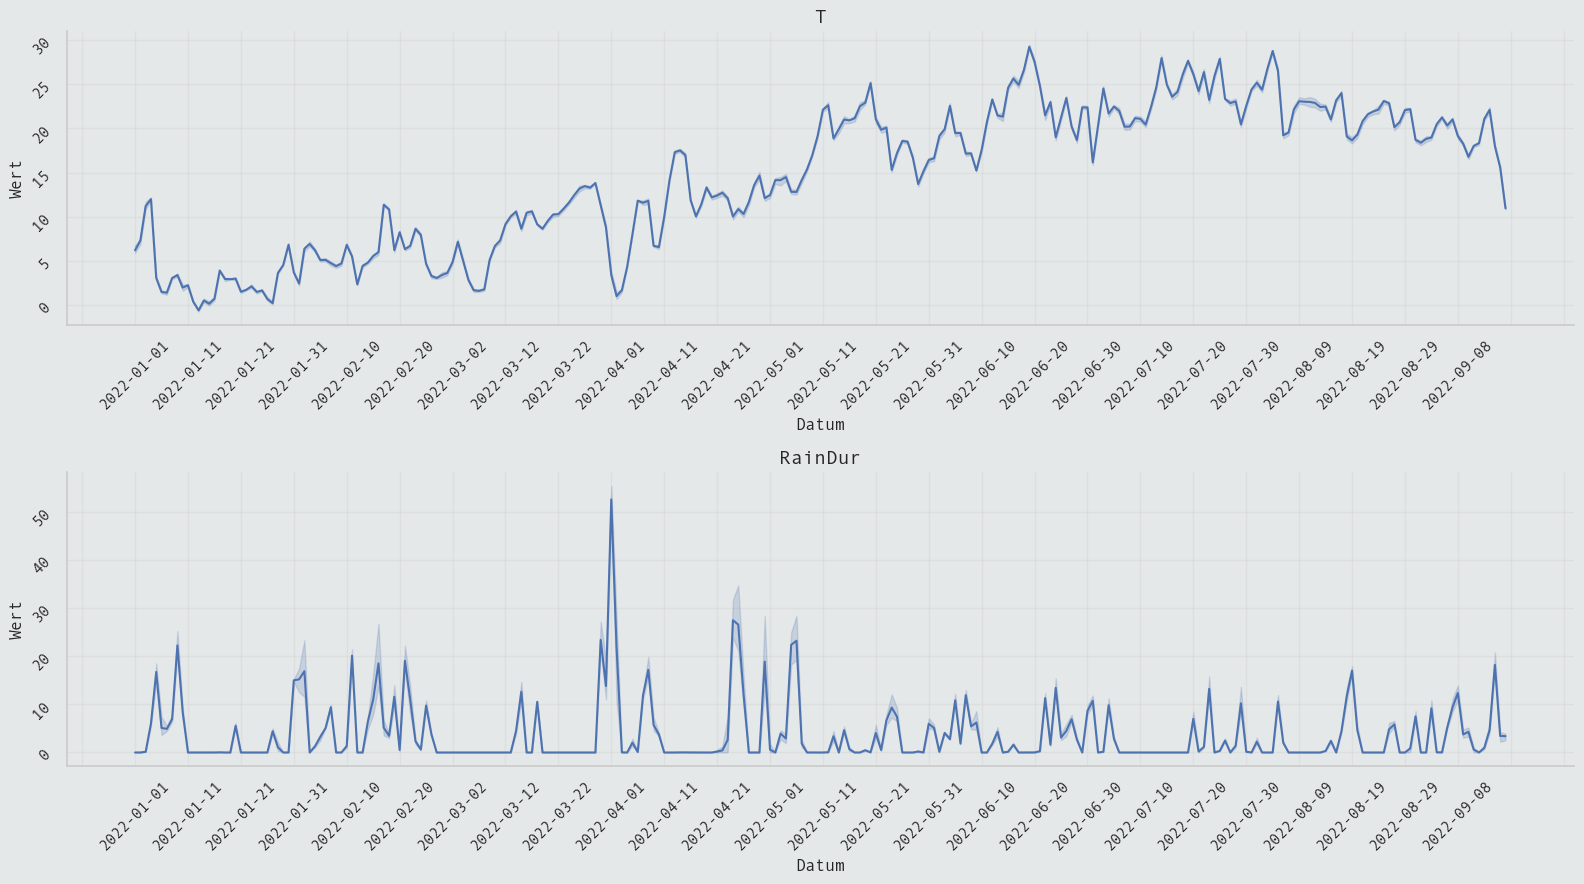

In [17]:
# Define the subplot
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, parameter in enumerate(precipitations_temperatures_2022['Parameter'].unique()):
    
    # Retrieve the data to plot
    data_plot = precipitations_temperatures_2022[precipitations_temperatures_2022['Parameter'] == parameter]
    
    # Define the plot
    sns.lineplot(data=data_plot.groupby([
                        data_plot.Datum.dt.strftime('%Y-%m-%d'), 
                        data_plot.Standort
                        ])['Wert'].mean().reset_index(), 
                 x='Datum', 
                 y='Wert', 
                 ax=ax[index])
    
    # Set the title
    ax[index].set_title(parameter, fontsize=14)
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
    
    ax[index].tick_params(labelrotation=45)
    
plt.tight_layout()

## CO2 Room A over Time

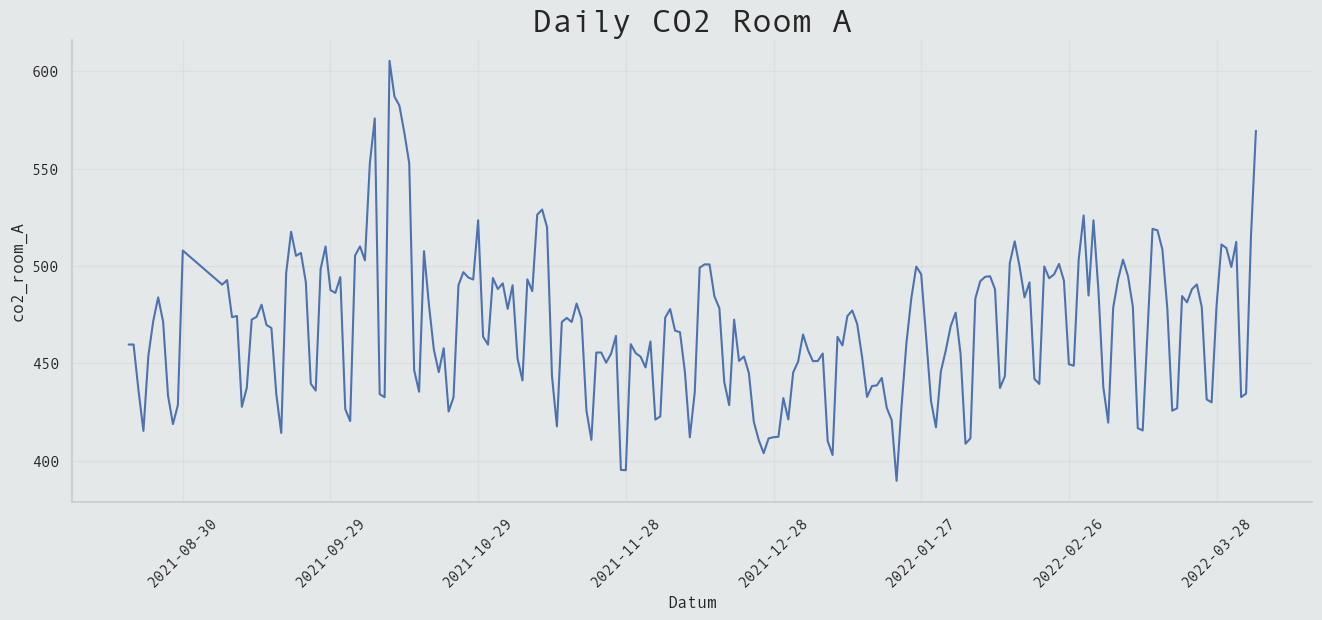

In [18]:
ax = sns.lineplot(
    data=sensirion_data.groupby([
        sensirion_data.Datum.dt.strftime('%Y-%m-%d')    
    ])['co2_room_A'].mean().reset_index(), 
    x='Datum', 
    y='co2_room_A'
)

ax.set_title('Daily CO2 Room A')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

## Number of Meals over Time

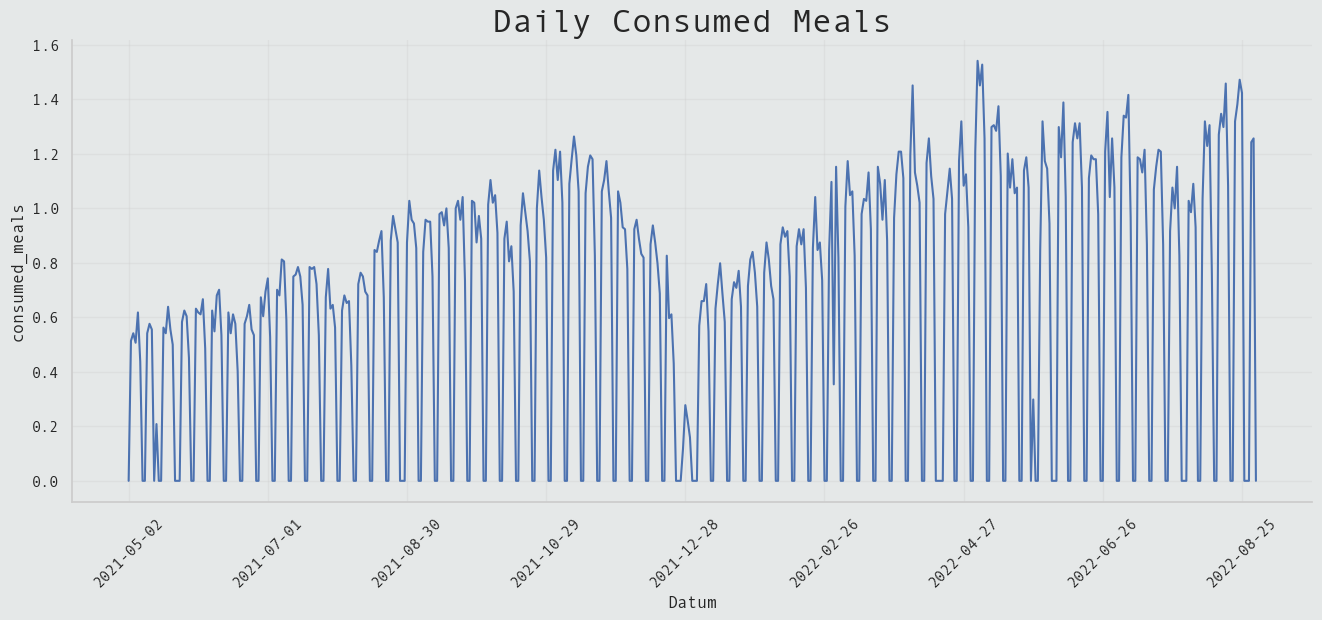

In [19]:
ax = sns.lineplot(
    data=sensirion_data.groupby([
        sensirion_data.Datum.dt.strftime('%Y-%m-%d')    
    ])['consumed_meals'].mean().reset_index(), 
    x='Datum', 
    y='consumed_meals'
)

ax.set_title('Daily Consumed Meals')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

# Data Pre-processing

## Create Dataset

In [37]:
# Aggregate Weather data per Standort with the mean
precipitations_2022_aggregated_standort = precipitations_2022.groupby(['Datum'])['Wert'].mean().reset_index()
precipitations_2022_aggregated_standort.rename(columns={'Datum': 'Datum', 'Wert': 'Precipitation'}, inplace=True)

temperatures_2022_aggregated_standort = temperatures_2022.groupby(['Datum'])['Wert'].mean().reset_index()
temperatures_2022_aggregated_standort.rename(columns={'Datum': 'Datum', 'Wert': 'Temperature'}, inplace=True)

In [38]:
# Aggregate Sensirion data per yyyy/mm/dd
sensirion_data['Datum'] = pd.to_datetime(sensirion_data['Datum'].dt.to_period('D').astype(str))
consumed_meals_aggregated_day = sensirion_data.groupby(['Datum'])['consumed_meals'].mean().reset_index()
co2_room_a_aggregated_day = sensirion_data.groupby(['Datum'])['co2_room_A'].mean().reset_index()

In [39]:
# Create the dataset
dataframes = [precipitations_2022_aggregated_standort, temperatures_2022_aggregated_standort, consumed_meals_aggregated_day, co2_room_a_aggregated_day]
dataset = reduce(lambda left,right: pd.merge(left,right,on=['Datum'], how='inner'), dataframes)

## Engineer Date

In [ ]:
# Compute 'day', 'month' and '
train_data['date_day'] = train_data['date_datetime'].dt.day
train_data['date_month'] = train_data['date_datetime'].dt.month

## Remove Weekends

We are not interested in weekends, since people are not going to work on those days.